In [1]:
# Model definition
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras import models
from keras import layers
from keras import optimizers
from keras.wrappers.scikit_learn import KerasRegressor

from keras.models import (load_model, )
from keras.applications import (VGG16,)
from keras.preprocessing.image import (ImageDataGenerator,image,)
from keras.datasets import (boston_housing,mnist)
from keras.utils import to_categorical

from sklearn.preprocessing  import ( StandardScaler,)
from sklearn.model_selection import ( train_test_split,KFold, )

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
data_augment = True

train_dir = "G:/KAGGLE/Cats And Dogs/train"
valid_dir = "G:/KAGGLE/Cats And Dogs/valid"
test_dir = "G:/KAGGLE/Cats And Dogs/test"

train_dir_cat = os.path.join(train_dir,"cat" )
train_dir_dog = os.path.join(train_dir,"dog" )

if (data_augment):
    train_datagen = ImageDataGenerator(
        rescale = 1./255, 
        rotation_range = 40,
        width_shift_range =0.2,
        height_shift_range =0.2, 
        shear_range=0.2,
        zoom_range =0.2,
        horizontal_flip = True,
        fill_mode = 'nearest')
else:
    train_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size = (150,150), batch_size = 20, class_mode= 'binary') 
valid_generator = test_datagen.flow_from_directory(valid_dir, target_size = (150,150), batch_size = 20, class_mode= 'binary') 



Found 24600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [40]:
def build_model(dropout = True):
    model = models.Sequential()
    model.add(layers.Conv2D(32,(3,3),activation='relu', input_shape = (150,150,3)))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(64,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128,(3,3),activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(128,(3,3),activation='relu'))

    model.add(layers.Flatten())
    if (dropout):
        model.add(layers.Dropout(0.5))
        
    model.add(layers.Dense(512, activation= 'relu'))
    model.add(layers.Dense(1, activation= 'sigmoid'))
    return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [41]:
model.compile(optimizer = optimizers.RMSprop(lr=1e-4), loss = 'binary_crossentropy', metrics = ['acc'])
#model.fit(train_images, train_labels, epochs=5, batch_size=1000)

# model

In [ ]:
epochs = 20
history = model.fit_generator(train_generator, steps_per_epoch = 50, epochs = epochs, 
                              validation_data = valid_generator, validation_steps = 50)

timestamp_str = datetime.datetime.now().strftime('%Y%m%d-%H%m%S')
model.save('cats_dogs_%s.h5' % timestamp_str)

In [3]:
def plot_history(history):
    plt.plot(range(0,epochs),history.history["acc"], label = "train acc")
    plt.plot(range(0,epochs),history.history["val_acc"],label = "valid  acc")
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("accuracy")

    plt.figure()
    plt.plot(range(0,epochs),history.history["loss"], label = "train loss")
    plt.plot(range(0,epochs),history.history["val_loss"],label = "valid  loss")
    #plt.plot(epochs,history.history["mae"],label = "mae")
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("loss")

# DATA AUGMENTATION


In [36]:
plot_history(history)

Found 24800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


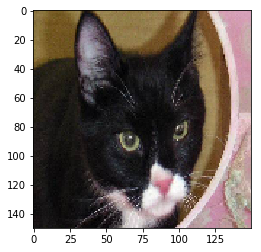

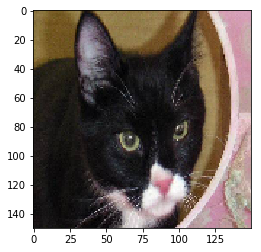

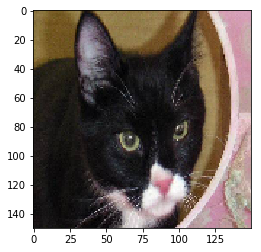

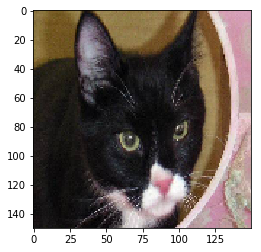

In [43]:
fnames = [ os.path.join(train_dir_cat, fname) for fname in os.listdir(train_dir_cat) ]
img_path = fnames[3]
img = image.load_img(img_path, target_size = [150,150])
x = image.img_to_array(img)
x = x .reshape((1,) + x.shape)
i = 0
for batch in datagen.flow(x, batch_size=1 ):
    plt.figure(i)
    imgpot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i == 4:
        break

#Using VGG16


In [4]:
conv_base = VGG16(weights='imagenet', include_top = False, input_shape=(150,150,3))
conv_base.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [5]:
batch_size = 20
datagen = ImageDataGenerator(rescale = 1./255)

def extract_features(directory,sample_count):

    features = np.zeros(shape =(sample_count,4,4,512))
    labels = np.zeros(shape = (sample_count))
    generator = datagen.flow_from_directory(
        directory, 
        target_size=(150,150), 
        batch_size = batch_size, 
        class_mode="binary")
    i = 0
    for input_batch, labels_batch in generator:
        features_batch = conv_base.predict(input_batch)
        features[i * batch_size: (i+1)* batch_size] = features_batch
        labels[i * batch_size: (i+1)* batch_size] = labels_batch
        i+=1
        if i * batch_size >= sample_count:
            break
    return features, labels
print(train_dir)
train_size = 1000 
valid_size = 200
train_features, train_labels = extract_features(train_dir,train_size)
train_features = np.reshape(train_features,(train_size,4*4*512))
print(valid_dir)
valid_features, valid_labels = extract_features(valid_dir,valid_size)
valid_features = np.reshape(valid_features,(valid_size,4*4*512))
print(test_dir)
#test_features, test_labels = extract_features(test_dir,2000)

G:/KAGGLE/Cats And Dogs/train
Found 24600 images belonging to 2 classes.
G:/KAGGLE/Cats And Dogs/valid
Found 400 images belonging to 2 classes.
G:/KAGGLE/Cats And Dogs/test


In [8]:
epochs = 5
# fast but without aumentaton - overfitting
def build_model2():
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu',input_dim = 4*4*512))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    print(model.summary())
    return model

# slow but can use data augentaion to avoid overfitting
def extend_model(conv_base):
    conv_base.trainable = False
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))

    print(model.summary())
    return model

model = extend_model(conv_base)

model.compile(optimizer= optimizers.RMSprop(lr=2e-5),
                  loss="binary_crossentropy", 
                  metrics=['acc'])

if data_augment:
    history = model.fit_generator(train_generator, steps_per_epoch = 100, epochs = epochs,
                    validation_data=valid_generator, validation_steps = 50)

else:
    history = model.fit(train_features, train_labels, epochs = epochs,
                    batch_size = batch_size,
                    validation_data=(valid_features, valid_labels))


<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x000001F593F2BDD8>>
Epoch 1/5
100/100 [==============================] - 273s 3s/step - loss: 0.6666 - acc: 0.5995 - val_loss: 0.4913 - val_acc: 0.7880
Epoch 2/5
100/100 [==============================] - 279s 3s/step - loss: 0.5637 - acc: 0.7130 - val_loss: 0.4086 - val_acc: 0.8370
Epoch 3/5
100/100 [==============================] - 281s 3s/step - loss: 0.4883 - acc: 0.7695 - val_loss: 0.3648 - val_acc: 0.8500
Epoch 4/5
100/100 [==============================] - 285s 3s/step - loss: 0.4674 - acc: 0.7800 - val_loss: 0.3339 - val_acc: 0.8520
Epoch 5/5
100/100 [==============================] - 289s 3s/step - loss: 0.4549 - acc: 0.7865 - val_loss: 0.3062 - val_acc: 0.8880


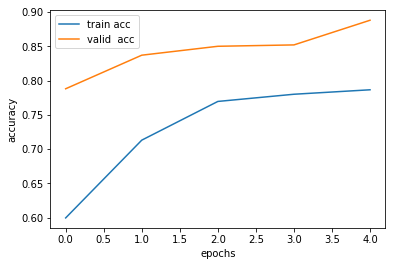

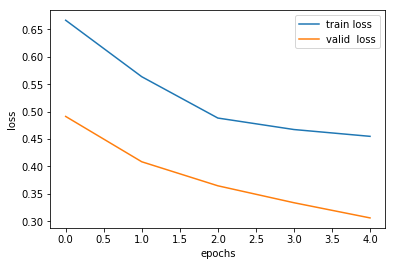

In [9]:
plot_history(history)
model.save('cats_dogs_vgg16.h5')

In [60]:
train_features = np.reshape(train_features,(train_size,4*4*512))
valid_features.shape
train_features.shape

(1000, 8192)

# 5.4 Visualization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


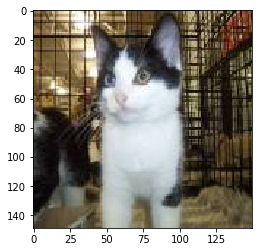

In [12]:
model = load_model('cats_dogs_vgg16.h5')
model.summary()
img = image.load_img(os.path.join(train_dir, "cat/cat.1000.jpg"))
img_tensor = image.img_to_array(img)
img_tensor  = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255

plt.imshow(img_tensor[0])
plt.show()